## Load Imports

In [1]:
# python imports
import os
import re
import json
from math import pi

# third-party imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec

## Config

In [2]:
NETWORK_NAME = 'Network01'
PREFIX = 'scenario-1'

DRAW_TITLE = False
SAVE_FIG = False

OUTPUT_FIG = 'imgs'
EXTENSION = 'pdf'

## Globals variables

In [3]:
COLUMNS = [
    'base_score', 'cve_published_date', 'exploit_count', 'exploit_published_date', 'epss', 'topology', 'asset_type', 
    'environment', 'sensitive_data', 'end_of_life', 'critical_asset', 'attack_type_arbitrary_code_execution', 
    'attack_type_defense_in_depth', 'attack_type_denial_of_service', 'attack_type_elevation_of_privilege', 
    'attack_type_information_disclosure', 'attack_type_memory_leak', 'attack_type_none', 'attack_type_proof_of_concepts', 
    'attack_type_remote_code_execution', 'attack_type_security_feature_bypass', 'attack_type_spoofing', 
    'attack_type_sql_injection', 'attack_type_tampering', 'attack_type_xss', 'attack_type_zero_day', 
    'availability_impact_high', 'availability_impact_low', 'availability_impact_none', 'confidentiality_impact_high', 
    'confidentiality_impact_low', 'confidentiality_impact_none', 'integrity_impact_high', 'integrity_impact_low', 
    'integrity_impact_none', 'part_application', 'part_hardware', 'part_operating_system', 'vendor_adobe', 'vendor_apple', 
    'vendor_cisco', 'vendor_debian', 'vendor_google', 'vendor_ibm', 'vendor_linux', 'vendor_microsoft', 'vendor_oracle', 
    'vendor_other', 'vendor_redhat', 'mitre_top_25', 'owasp_top_10', 'security_advisory', 'audience', 'google_interest',
    'google_trend_decreasing', 'google_trend_increasing', 'google_trend_none', 'google_trend_steady']

SEVERITY_LABELS = ['LOW', 'MEDIUM', 'HIGH', 'CRITICAL']
RISK_LABELS = ['LOW', 'MODERATE', 'IMPORTANT', 'CRITICAL']

COLORS = {
    'LOW': '#14943D',
    'MEDIUM': '#FDBE0E',
    'MODERATE': '#FDBE0E',
    'HIGH': '#FC7303',
    'IMPORTANT': '#FC7303',
    'CRITICAL': '#F20101'
}

## Utils

In [4]:
def flatten_dict(vulns_dist, keys):
    tmp_list = {key: [] for key in keys}

    for dist in vulns_dist:
        for key, value in dist.items():
            tmp_list[key].append(value)

    return tmp_list

In [5]:
# https://en.wikipedia.org/wiki/Shoelace_formula
def poligon_area(theta, r):
    # turn radial grid points into (x, y)
    x = r[:-1] * np.sin(theta[:-1])
    y = r[:-1] * np.cos(theta[:-1])

    return 0.5 * np.abs(np.dot(x[:-1], np.roll(y[:-1], 1)) - np.dot(y[:-1], np.roll(x[:-1], 1)))

In [6]:
# https://www.pythoncharts.com/matplotlib/radar-charts/
def print_polar_graph(ax, cvss_stats, frape_stats, key, draw_title=True,
                      draw_labels=True, draw_legend=True):
    cvss = cvss_stats.iloc[[key]]
    cvss = np.squeeze(cvss.values).tolist()

    frape = frape_stats.iloc[[key]]
    frape = np.squeeze(frape.values).tolist()

    labels = cvss_stats.columns.tolist()

    if not draw_labels:
        labels = ['' for _ in labels]

    angles = np.linspace(start=0, stop=2 * np.pi, num=len(labels), endpoint=False).tolist()

    cvss += cvss[:1]
    frape += frape[:1]
    labels += labels[:1]
    angles += angles[:1]

    ax.plot(angles, cvss, color='#3E6D9C', linewidth=1, label='CVSS')
    ax.fill(angles, cvss, color='#3E6D9C', alpha=0.25)

    ax.plot(angles, frape, color='#FD841F', linewidth=1, label='FRAPE')
    ax.fill(angles, frape, color='#FD841F', alpha=0.25)

    # Fix axis to go in the right order and start at 12 o'clock.
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # Draw axis lines for each angle and label.
    ax.set_thetagrids(np.degrees(angles), labels)

    # Go through labels and adjust alignment based on where
    # it is in the circle.
    for label, angle in zip(ax.get_xticklabels(), angles):
        if angle in (0, np.pi):
            label.set_horizontalalignment('center')
        elif 0 < angle < np.pi:
            label.set_horizontalalignment('left')
        else:
            label.set_horizontalalignment('right')

    # Ensure radar goes from 0 to 100.
    ax.set_ylim(0, 1)
    # You can also set gridlines manually like this:
    # ax.set_rgrids([0.2, 0.4, 0.6, 0.8, 1.0])

    # Set position of y-labels (0-100) to be in the middle
    # of the first two axes.
    ax.set_rlabel_position(180 / len(labels))

    # Add some custom styling.
    # Change the color of the tick labels.
    ax.tick_params(colors='#222222')
    # Make the y-axis (0-100) labels smaller.
    ax.tick_params(axis='y', labelsize=8)
    # Change the color of the circular gridlines.
    ax.grid(color='#AAAAAA')
    # Change the color of the outermost gridline (the spine).
    ax.spines['polar'].set_color('#222222')
    # Change the background color inside the circle itself.
    ax.set_facecolor('#FAFAFA')

    # Add title.
    if draw_title:
        ax.set_title(f'Iteração {key}', y=1.08, size=10)

    # Add a legend as well.
    if draw_legend:
        ax.legend(loc='center left', bbox_to_anchor=(1.6, 0))

In [7]:
def print_polar_graphs(cvss_stats, frape_stats):
    fig = plt.figure(figsize=(7, 9), constrained_layout=True)

    if DRAW_TITLE:
        fig.suptitle('Superfícies de Ataque')

    gs = GridSpec(4, 3, figure=fig)

    key = 0

    for row in range(4):

        if row == 0:
            ax = fig.add_subplot(gs[row, :], polar=True)
            print_polar_graph(ax, cvss_stats, frape_stats, key, draw_title=False)
        else:
            for col in range(3):
                key += 10

                ax = fig.add_subplot(gs[row, col], polar=True)
                print_polar_graph(ax, cvss_stats, frape_stats, key, draw_title=True,
                                  draw_labels=False, draw_legend=False)

    if SAVE_FIG:
        plt.savefig(f'{OUTPUT_FIG}/{PREFIX}-spiderchart.{EXTENSION}', bbox_inches='tight', dpi=1200)

In [8]:
def print_feature_importances(features, names, stds):
    fig, ax = plt.subplots(figsize=(6, 4))

    features.plot.bar(yerr=stds, ax=ax)
    
    if DRAW_TITLE:
        ax.set_title('Relevância dos Atributos')

    ax.set_ylabel('Valores Médios Absolutos de Shapley')

    ax.set_xticklabels(names, rotation=85)
    
    if SAVE_FIG:
        plt.savefig(f'{OUTPUT_FIG}/{PREFIX}-model-feature-importances.{EXTENSION}', bbox_inches='tight', dpi=1200)

    plt.show()

In [9]:
def print_auc_graph(cvss_stats, frape_stats, name, text_offset=(1, 1), limit=None):

    cvss_area = list()
    frape_area = list()

    for key in range(len(cvss_stats)):

        cvss = cvss_stats.iloc[[key]]
        cvss = np.squeeze(cvss.values).tolist()

        frape = frape_stats.iloc[[key]]
        frape = np.squeeze(frape.values).tolist()

        labels = cvss_stats.columns.tolist()

        angles = np.linspace(start=0, stop=2 * np.pi, num=len(labels), endpoint=False).tolist()

        # closing the polygon
        cvss += cvss[:1]
        frape += frape[:1]
        angles += angles[:1]

        cvss_area.append(poligon_area(angles, cvss))
        frape_area.append(poligon_area(angles, frape))
    
    limit = limit if limit else len(cvss_area)
    
    cvss_area = np.array(cvss_area)[:limit]
    frape_area = np.array(frape_area)[:limit]
    
    # normalizing area values
    
    max_values = [*cvss_area, *frape_area]
    
    cvss_area = cvss_area / max(max_values)
    frape_area = frape_area / max(max_values)
        
    # calculating delta values
    
    delta = [frape - cvss for cvss, frape in zip(cvss_area, frape_area)]

    min_value = min(delta)
    min_index = delta.index(min_value)
    
    # drawing graph

    fig, ax = plt.subplots(figsize=(6, 4))

    if DRAW_TITLE:
        fig.suptitle('Evolução da Superfície de Ataque')
                    
    if name == 'absolute':
                
        ax.plot(range(limit), cvss_area, label='CVSS')
        ax.plot(range(limit), frape_area, label='FRAPE')

        ax.annotate(f'Ganho Máximo do FRAPE ({round(abs(min_value) * 100)}%)',
                    xy=(min_index, frape_area[min_index]), xycoords='data',
                    xytext=text_offset, textcoords='offset points')

        ax.annotate('', xy=(min_index, frape_area[min_index]), 
                    xytext=(min_index, cvss_area[min_index]),
                    arrowprops=dict(arrowstyle="<->", color='black', linestyle='--'))      

        ax.set_ylabel('Área Sob a Curva (AUC) Normalizada')
        ax.set_xlabel('Iteração do Simulador')

        ax.legend(prop={'size': 11})
        ax.grid(True, linestyle='--', alpha=.25)
    
    if name == 'delta':
            
        ax.plot(range(limit), np.array(delta) * 100)
        ax.axhline(y=0.0, color='r', linestyle='--', linewidth=1.0)

        ax.set_ylabel(r'$\Delta_{AUC} = $ 100 * (FRAPE - CVSS)')
        ax.set_xlabel('Iteração do Simulador')

        ax.grid(True, linestyle='--', alpha=.25)

    if SAVE_FIG:
        plt.savefig(f'{OUTPUT_FIG}/{PREFIX}-{name}-auc-graph.{EXTENSION}', bbox_inches='tight', dpi=1200)
    
    plt.show()

In [10]:
def print_vuln_dist(cvss, frape, name, limit=1):

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True, constrained_layout=True)

    if DRAW_TITLE:    
        fig.suptitle(f'Distribuição das Vulnerabilidades pelo {name}', size=14)

    fig.supylabel('Número de Vulnerabilidades')

    titles = ['(a) metodologia #1: CVSS', '(b) metodologia #2: FRAPE']

    _cvss = cvss[:limit]
    _frape = frape[:limit]

    def get_mean(df):
        mean = pd.DataFrame()
        for index, item in enumerate(df):
            if index == 0:
                mean = pd.DataFrame(item)
            else:
                mean += pd.DataFrame(item)
        return mean / len(df)

    _cvss = [*_cvss, get_mean(_cvss)]
    _frape = [*_frape, get_mean(_frape)]

    for ax, title, vuln_list in zip(axes, titles, [_cvss, _frape]):

        ax.set_title(title, size=12)

        for index, dist in enumerate(vuln_list):

            alpha = 1.0 if index == limit else 0.30
            linewidth = 2.0 if index == limit else 1.0

            for key, values in dist.items():
                ax.plot(range(len(values)), values, label=key.upper(),
                        color=COLORS[key], alpha=alpha, linewidth=linewidth)
                ax.set_xlabel('Iterações do Simulador', size=12)

        ax.grid(True, linestyle='--', alpha=.25)

    handles = [mpatches.Patch(color=COLORS[key], label=key) for key in _cvss[0].keys()][::-1]
    axes[0].legend(handles=handles, loc='upper right')
    axes[1].legend(handles=handles, loc='upper right')

    if SAVE_FIG:
        name = re.sub(r"\s+", '-', name)
        plt.savefig(f'{OUTPUT_FIG}/{PREFIX}-vuln-dist-{name.lower()}.{EXTENSION}', bbox_inches='tight', dpi=1200)
    
    plt.show()

## Loading data

In [11]:
feature_importances = {name: [] for name in COLUMNS}

cvss_base_severity = list()
cvss_risk_score = list()

frape_base_severity = list()
frape_risk_score = list()

cvss_cdf = pd.DataFrame(columns=COLUMNS)
frape_cdf = pd.DataFrame(columns=COLUMNS)

cvss_abs_values = pd.DataFrame(columns=COLUMNS)
frape_abs_values = pd.DataFrame(columns=COLUMNS)

occurrences = 0

In [12]:
for file in os.listdir(f'../output/{NETWORK_NAME}/'):
    if file.endswith('.json'):
        with open(f'../output/{NETWORK_NAME}/{file}') as f:

            file = json.load(f)

            # loading values

            features = pd.Series(file['feature_importances'])

            cvss_severity = file['stats']['cvss']['base_severity']
            frape_severity = file['stats']['frape']['base_severity']

            cvss_risk = file['stats']['cvss']['risk_score']
            frape_risk = file['stats']['frape']['risk_score']
            
            cvss_abs = pd.DataFrame.from_records(file['stats']['cvss']['abs_values'])
            frape_abs = pd.DataFrame.from_records(file['stats']['frape']['abs_values'])
            
            # loading feature importances

            for name, value in zip(features.index, features.values):
                feature_importances[name].append(value)

            # loading base severity and risk score

            cvss_base_severity.append(flatten_dict(cvss_severity, SEVERITY_LABELS))
            frape_base_severity.append(flatten_dict(frape_severity, SEVERITY_LABELS))

            cvss_risk_score.append(flatten_dict(cvss_risk, RISK_LABELS))
            frape_risk_score.append(flatten_dict(frape_risk, RISK_LABELS))
            
            # normalizing values
                        
            cvss_frape_abs = pd.concat([cvss_abs, frape_abs])
            
            cvss_abs = cvss_abs / cvss_frape_abs.max(axis=0)
            frape_abs = frape_abs / cvss_frape_abs.max(axis=0)
            
            if occurrences == 0:
                cvss_abs_values = cvss_abs
                frape_abs_values = frape_abs
            else:
                cvss_abs_values += cvss_abs
                frape_abs_values += frape_abs
                
            occurrences += 1

## Pre-processing

In [13]:
# calcularing mean values

cvss_abs_values /= occurrences
frape_abs_values /= occurrences

# sorting feature importance values

feature_importances = pd.DataFrame(feature_importances, columns=feature_importances.keys())

feature_importances_std = feature_importances.std()
feature_importances = feature_importances.mean()

feature_importances.drop(labels=['cve_published_date', 'exploit_published_date', 
                                 'vendor_other', 'attack_type_none'], inplace=True)


feature_importances = feature_importances.sort_values(ascending=False).head(9)
feature_importance_names = feature_importances.index.tolist()
feature_importances_std = feature_importances_std[feature_importance_names].values

# filtering absolute values

cvss_abs_values = cvss_abs_values[feature_importance_names]
frape_abs_values = frape_abs_values[feature_importance_names]

## Running

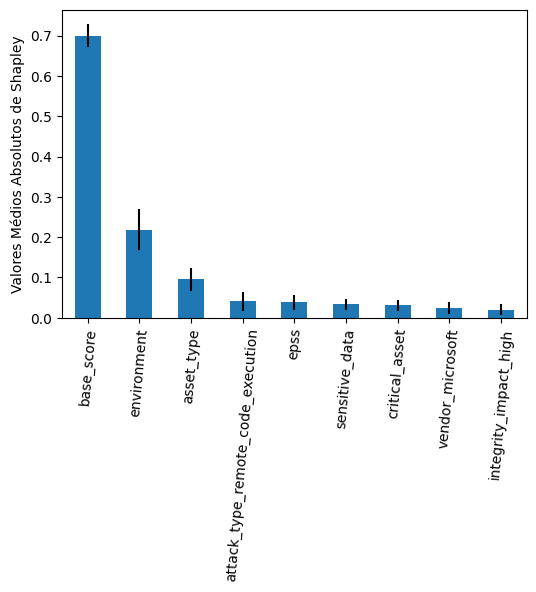

In [14]:
print_feature_importances(feature_importances, feature_importance_names, feature_importances_std)

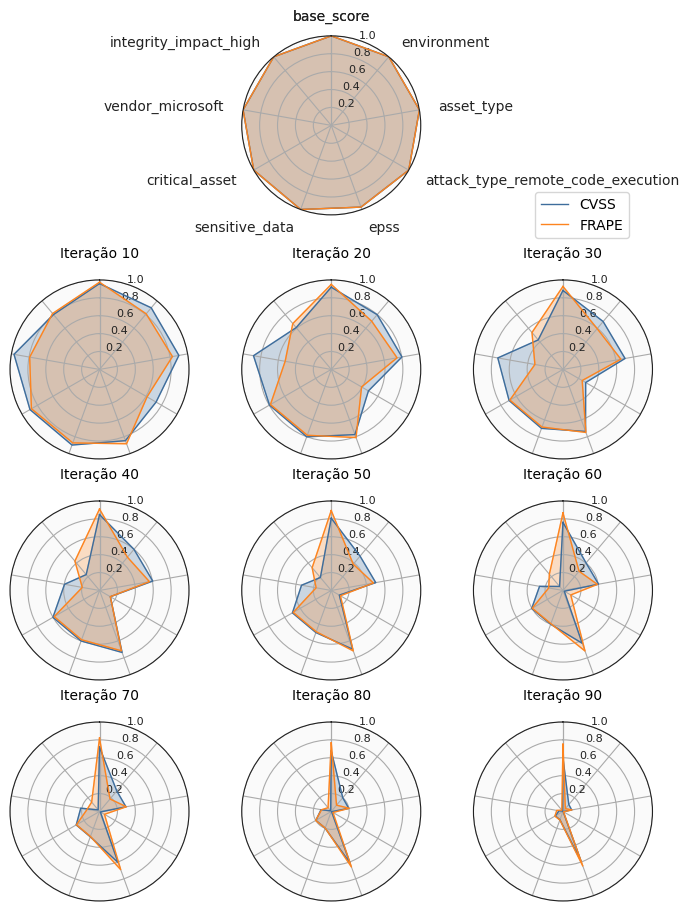

In [15]:
print_polar_graphs(cvss_abs_values, frape_abs_values)

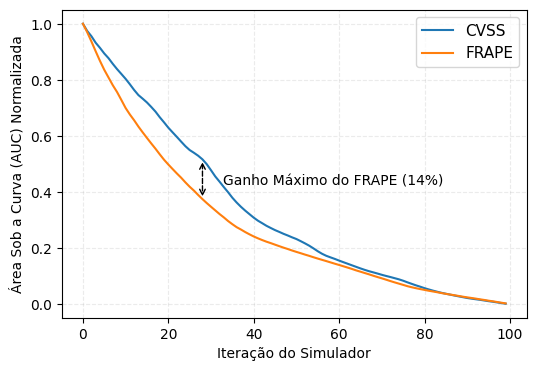

In [16]:
print_auc_graph(cvss_abs_values, frape_abs_values, 'absolute', text_offset=(15, 10))

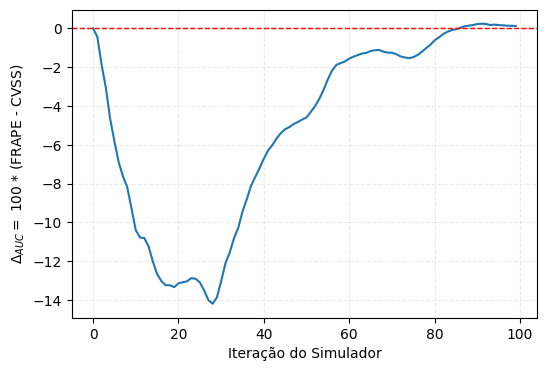

In [17]:
print_auc_graph(cvss_abs_values, frape_abs_values, 'delta')

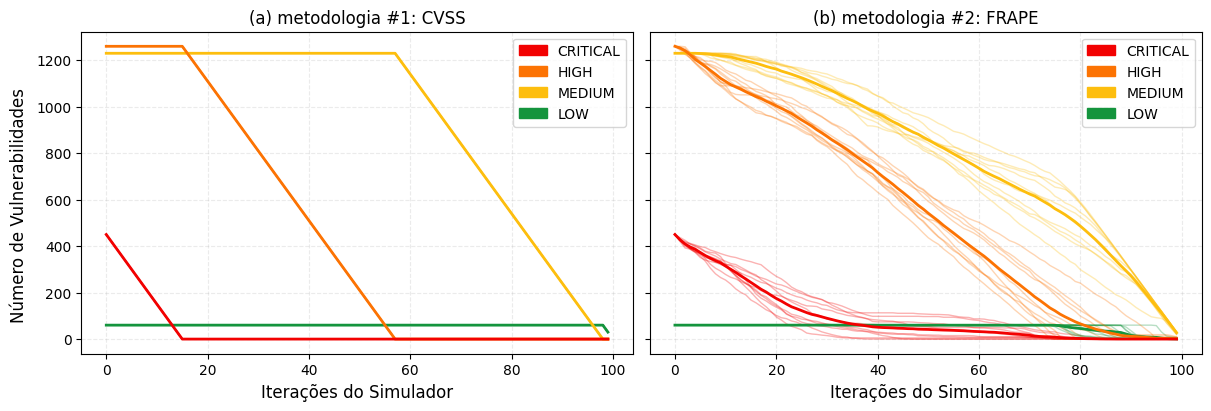

In [18]:
print_vuln_dist(cvss_base_severity, frape_base_severity, 'Base Severity', limit=10)

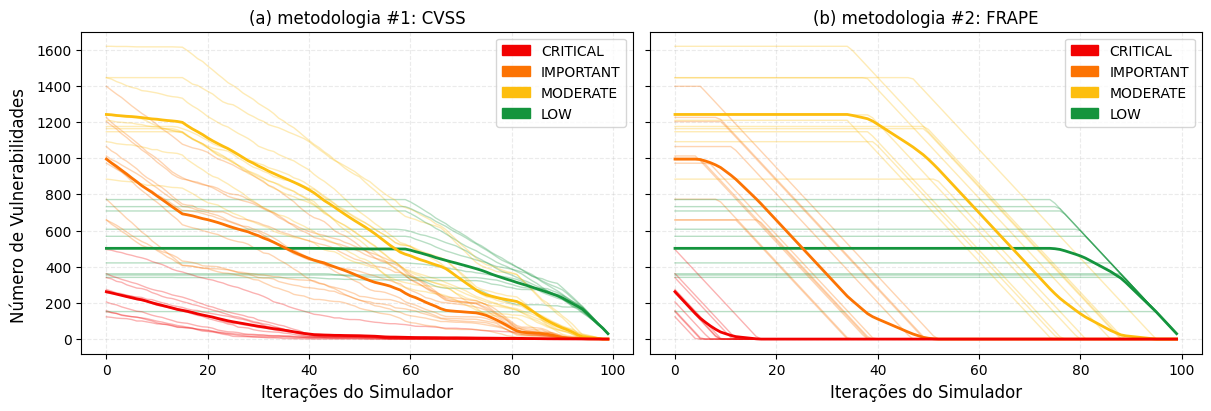

In [19]:
print_vuln_dist(cvss_risk_score, frape_risk_score, 'Risk Score', limit=10)